<a href="https://www.kaggle.com/code/abhijitbhandari/glove-lstm-truthguard-unmasking-deception?scriptVersionId=142198356" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# !pip install seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split

# !pip install nltk
# !pip install scikit-learn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Dropout, BatchNormalization, Embedding
from tqdm.auto import tqdm

In [5]:
!pip install nltk
import nltk
import re
from nltk.corpus import stopwords
#import spacy ##can be used if we want to lemmatize

In [6]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading the Dataset

In [7]:
train = pd.read_csv("/kaggle/input/fake-news/train.csv")
train.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
train.shape

(20800, 5)

## Data Wrangling

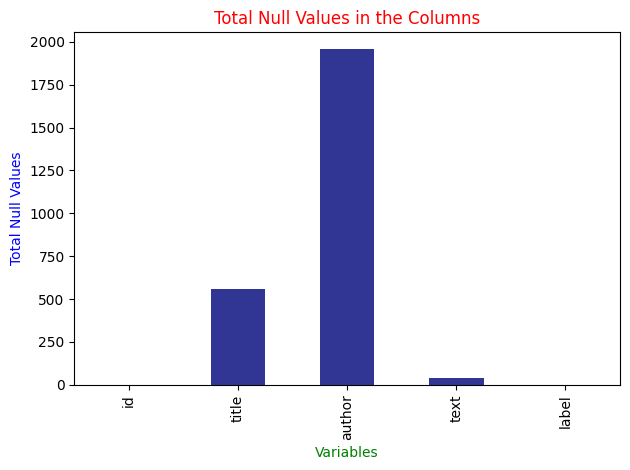

In [9]:
train.isnull().sum().plot(kind = "bar", cmap = "RdYlBu_r")
plt.xlabel("Variables", color = "Green")
plt.ylabel("Total Null Values",color = "Blue")
plt.title("Total Null Values in the Columns", color = "Red")
plt.tight_layout()

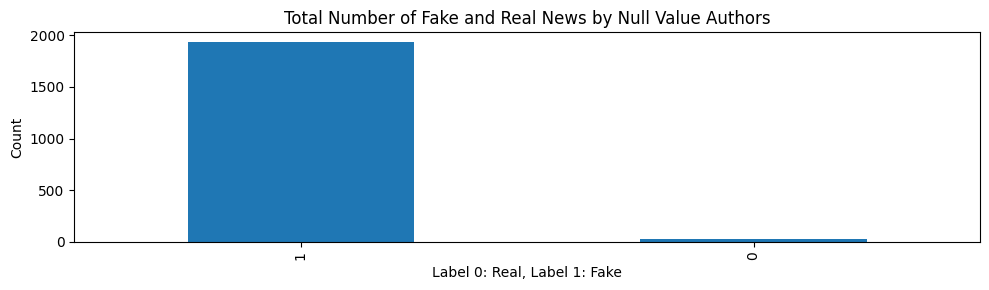

In [10]:
plt.figure(figsize = (10,3))
train[train["author"].isna()]["label"].value_counts().plot(kind = "bar")
plt.xlabel(f"Label 0: Real, Label 1: Fake")
plt.ylabel("Count")
plt.title("Total Number of Fake and Real News by Null Value Authors")
plt.tight_layout()

**Since a significant number of fake news articles do not have the author's name, it can provide valuable information for our model to learn from. Therefore, we will replace all the null values in the 'author' column with 'Not Given'.**

<Axes: >

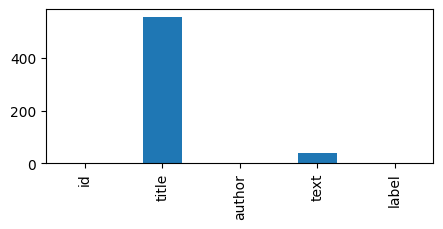

In [11]:
train["author"].fillna("Not Given",inplace = True)
train.isnull().sum().plot(kind = "bar", figsize = (5,2))

<Axes: >

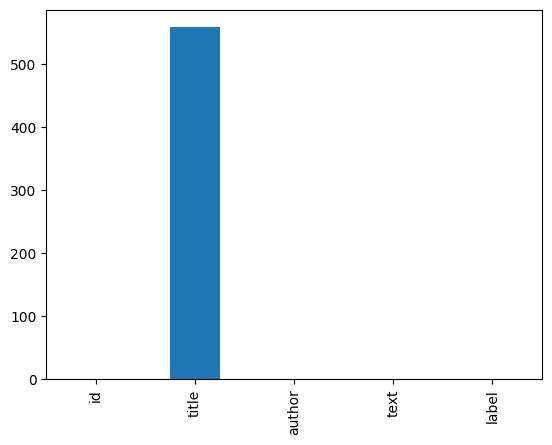

In [12]:
## Checking the null values in title column
train[train["title"].isna()].isnull().sum().plot(kind = "bar")

**Wherever the 'title' is null, the 'text' is not null; only the 'title' is missing.**

In [13]:
## Checking if null titles have relationship with null authors
(train["title"].isna()& (train["author"]=="Not Given")).sum()

0

**No relationship found**

<Axes: >

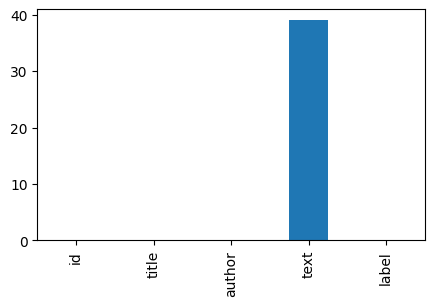

In [14]:
## Replacing null title with Not Given
train["title"].fillna("Not Given", inplace = True)
train.isnull().sum().plot(kind = "bar", figsize = (5,3))

In [15]:
## Removing all the null text
train.dropna(axis = 0, inplace = True)
train.shape

(20761, 5)

In [16]:
train.groupby("label")["label"].value_counts()

label
0    10387
1    10374
Name: count, dtype: int64

## Feature Engineering

In [17]:
## Extracting Independent Features
X = train.iloc[:, 1:-1]

## Extracting dependent Feature
y = train.iloc[:, -1]

In [18]:
X.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


## Model Development

In [19]:
messages = X.copy()

In [20]:
messages["author_text"] = messages["author"] + ": " + messages["text"]
messages.head()

,title,author,text,author_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus: House Dem Aide: We Didn’t Even ...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,Daniel J. Flynn: Ever get the feeling your lif...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com: Why the Truth Might Get Yo...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss: Videos 15 Civilians Killed In...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy: Print \nAn Iranian woman has b...


In [21]:
messages.reset_index(inplace = True, drop = True)
messages.head()

,title,author,text,author_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus: House Dem Aide: We Didn’t Even ...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,Daniel J. Flynn: Ever get the feeling your lif...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com: Why the Truth Might Get Yo...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss: Videos 15 Civilians Killed In...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy: Print \nAn Iranian woman has b...


### Working with the data

In [22]:
# # from nltk.stem import PorterStemmer
# # ps = PorterStemmer()
# corpus = []

# for i in range(len(messages)):
#     text = re.sub("[^a-zA-Z0-9]", " ",messages["author_text"][i])
#     text = text.lower()
#     text = text.split()
#     text = [word for word in text if word not in stopwords.words("english")]
#     corpus.append(" ".join(text))

In [23]:
# import json
# with open("fake_news_corpus.json","w") as f:
#     json.dump(corpus, f)

In [24]:
with open("/kaggle/input/train-corpus/fake_news_corpus.json", "r") as file:
    corpus = json.load(file)

In [25]:
corpus[0]

'darrell lucus house dem aide even see comey letter jason chaffetz tweeted darrell lucus october 30 2016 subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commons license apologies keith olbermann doubt worst person world week fbi director james comey according house democratic aide looks like also know second worst person well turns comey sent infamous letter announcing fbi looking emails may related hillary clinton email server ranking democrats relevant committees hear comey found via tweet one republican committee chairmen know comey notified republican chairmen democratic ranking members house intelligence judiciary oversight committees agency reviewing emails recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence emails appear pertinent investigation case reopened jason chaffetz jasoninthehous

In [26]:
len(corpus)

20761

In [27]:
# onehot_repr = [one_hot(word,voc_size) for word in corpus]

In [28]:
# len(onehot_repr[0])

### Applying the Pretrained Embedding: GloveVec

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [30]:
vocab_size = len(tokenizer.word_index)+1
sequences = tokenizer.texts_to_sequences(corpus)

In [31]:
## Padding Sequences
max_length = max([len(sequence) for sequence in sequences])
X = pad_sequences(sequences, maxlen=max_length)

In [32]:
max_length

12430

In [33]:
## Loading Glove Embedding
embedding_dim = 100 #Matching Glove Embedding Size
glove_embedding_words = {}
with open("/kaggle/input/embedding-vector-glove100d/glove.6B.100d_set.txt", encoding = "utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype = "float32")
        glove_embedding_words[word] = vector

In [34]:
print(glove_embedding_words["play"])
print(glove_embedding_words["football"])

[-0.24078    0.024725   0.64615   -0.39997   -0.35115    0.74561
  0.25299    0.14074   -0.93186   -0.35508   -0.058308  -0.46291
 -0.3528     0.1506    -0.15477    0.22086    0.19687    0.93855
 -0.30118    0.66507    0.023788   0.12019    0.40891    0.35764
  0.72717   -0.39418   -0.35709   -0.50793    0.72475    0.52385
 -1.4761     0.98365    0.15173   -0.20473    0.43782   -0.3446
 -0.53396    0.5334    -0.68658   -0.56673    0.31568   -0.053152
 -0.11944   -0.13686   -0.18978   -0.1227     0.1451    -0.64823
  0.25137   -1.237     -0.64253    0.40003   -0.058787   0.77354
  0.23924   -2.9341    -0.30866   -0.44292    0.69635    0.91667
 -0.68562    0.9386    -0.75999   -0.10332    0.55076   -0.045999
  0.29313    0.63553   -0.64461   -0.081598  -0.042549  -0.66246
  0.56258   -0.40477    0.27864   -0.11477   -0.41308   -0.0098676
  0.16063    0.12854    0.49922   -0.07174   -0.52369   -0.047227
 -1.7793    -0.18095   -0.39465    0.18238   -0.10777   -0.20513
 -0.51512    0.10351 

In [35]:
## Creating embedding matrix
embedding_matrix = np.zeros(shape = (vocab_size, embedding_dim))
for word, pos in tokenizer.word_index.items():
    embedding_vector = glove_embedding_words.get(word, np.zeros(embedding_dim))
    embedding_matrix[pos] = embedding_vector

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14532, 12430)
(6229, 12430)
(14532,)
(6229,)


In [37]:
# ##Looking at the mimimum and maximum sentence lengths, the average sentence length must be kept 
## sentence_length = 10000
## embedded_text = pad_sequences(onehot_repr, 
##                               maxlen = sentence_length, 
##                               padding = "pre")

## print(embedded_text)

In [38]:
# # embedding_feature_vec = 300
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue = 0.5)
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                   output_dim = embedding_dim,
                    input_length = max_length,
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units = 200, dropout=0.2)))
model.add(BatchNormalization())
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy",
             optimizer = opt,
             metrics = ["accuracy"])
model.summary()
          

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12430, 100)        15288200  
                                                                 
 dropout (Dropout)           (None, 12430, 100)        0         
                                                                 
 bidirectional (Bidirectiona  (None, 400)              481600    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 15,771,801
Trainable params: 482,801
Non-t

In [39]:
# X_final = np.array(embedded_text)
# y_final = np.array(y)

In [40]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train,y_test = train_test_split(X_final, y_final,
#                                                   test_size = 0.30,
#                                                   random_state = 7)

In [41]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, 
                                              verbose = 1,
                                              restore_best_weights = True),
            tf.keras.callbacks.ReduceLROnPlateau(patience =3,
                                                 verbose = 1,
                                                 min_lr = 1e-4)]

In [42]:
history = model.fit(X_train, 
          y_train,
          batch_size = 7,
          epochs = 30,
          validation_data = (X_test, y_test),callbacks=callbacks)

Epoch 1/30
2076/2076 [==============================] - 2047s 982ms/step - loss: 0.4855 - accuracy: 0.7609 - val_loss: 0.2317 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 2/30
2076/2076 [==============================] - 2091s 1s/step - loss: 0.2663 - accuracy: 0.8942 - val_loss: 0.1198 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 3/30
2076/2076 [==============================] - 2097s 1s/step - loss: 0.1819 - accuracy: 0.9389 - val_loss: 0.0925 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 4/30
2076/2076 [==============================] - 2047s 986ms/step - loss: 0.1373 - accuracy: 0.9540 - val_loss: 0.0724 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 5/30
2076/2076 [==============================] - 2107s 1s/step - loss: 0.1714 - accuracy: 0.9398 - val_loss: 0.3978 - val_accuracy: 0.7961 - lr: 0.0010
Epoch 6/30
2076/2076 [==============================] - 2063s 994ms/step - loss: 0.1982 - accuracy: 0.9267 - val_loss: 0.1017 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 7/30
2076/2076 [===============

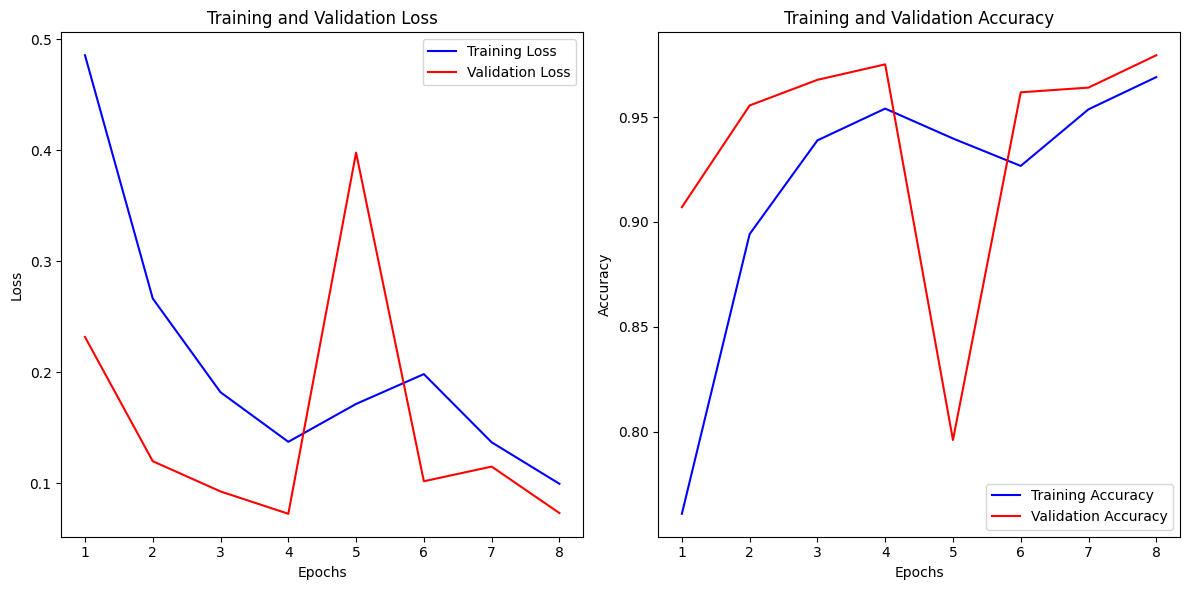

In [43]:
import matplotlib.pyplot as plt
                                        
# # Access training history from the 'history' object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']  
validation_accuracy = history.history['val_accuracy'] 

# # Create an array representing the number of epochs
epochs = range(1, len(training_loss) + 1)
                                        
# # Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
                                        
# # Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
model.save(filepath="./lstm_fake_news_model.h5")

### Loading the trained model

In [45]:
from keras.models import load_model
fakenews_detector = load_model("./lstm_fake_news_model.h5")

### Testing the Model in test data

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14532, 12430)
(6229, 12430)
(14532,)
(6229,)


In [47]:
batch_size = 8
num_samples = X_test.shape[0]
y_pred = []

for i in range(0,num_samples,batch_size):
    batch_x = X_test[i:i+batch_size]
    batch_pred = fakenews_detector.predict(batch_x)
    y_pred.extend(batch_pred)

y_pred = np.array(y_pred)
    
    

1/1 [==============================] - 0s 387ms/step


In [48]:
y_pred[2]

array([0.00611382], dtype=float32)

#### Using AUC ROC to find the suitable threshold

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
fpr,tpr, thresholds = roc_curve(y_test,y_pred)
auc_sore = roc_auc_score(y_test,y_pred)


# Find the threshold that maximizes Youden's J statistic
youden_j = tpr-fpr
optimal_threshold_index = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_threshold

0.4249139

In [50]:
optimal_threshold

0.4249139

In [51]:
predicted_labels = np.where(y_pred>=optimal_threshold,1,0)

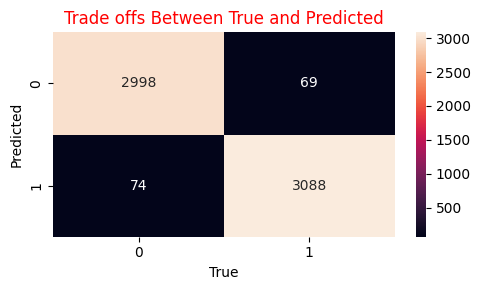

In [52]:
plt.figure(figsize = (5,3))
sns.heatmap(confusion_matrix(y_test, predicted_labels), annot = True,fmt = "")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Trade offs Between True and Predicted", color = "red")
plt.tight_layout()

In [53]:
print("Precision Score: ",precision_score(y_test, predicted_labels))
print("Recall Score: ", recall_score(y_test, predicted_labels))
print("f1 Score: ", f1_score(y_test, predicted_labels))
print("Accuracy Score: ", accuracy_score(y_test, predicted_labels))

Precision Score:  0.9781438074121
Recall Score:  0.9765970904490828
f1 Score:  0.9773698369995252
Accuracy Score:  0.9770428640231177


In [54]:
##Saving the tokenizer for future use
import pickle
with open("./tokenizer.pkl", "wb") as token_file:
    pickle.dump(tokenizer, token_file)

# Testing the Model in Given Test Data

#### Loading the Saved Model and Tokenizer

In [55]:
from keras.models import load_model
fakenews_detector = load_model("./lstm_fake_news_model.h5")

In [56]:
import pickle
with open("./tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

In [57]:
len(loaded_tokenizer.word_index)

152881

In [58]:
## Params for Prediction
optimal_threshold_sigmoid = optimal_threshold
max_length = max_length

#### Loading the Required Libraries

In [59]:
## Loading Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Loading the test Dataset

In [60]:
path1 = "/kaggle/input/fake-news/test.csv"
path2 = "/kaggle/input/fake-news/submit.csv"

test1 = pd.read_csv(path1)
test2 = pd.read_csv(path2)


In [61]:
test1.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [62]:
test2.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


**We can see that test1 has the text information and test2 has the labels for the data in the test data where 0 is Real and 1 is Fake**

In [63]:
## Merging test1 and test2 based on id column
test_data = test1.merge(test2, how = "left",on = "id")
test_data.shape

(5200, 5)

In [64]:
test_data.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [65]:
test_data.isnull().sum()

id          0
title     122
author    503
text        7
label       0
dtype: int64

#### Test Data Preprocessing

In [66]:
## The data preprocessing will follow exactly the same method as done for the train data
def data_correction(dataframe:pd.DataFrame, batch_size:int = 16):
    assert all(column for column in dataframe.columns for column in ["id", "title", "author", "text", "label"]), "Column Missing in DataFrame or Check the Column Names: Should be in order 'id', 'title', 'author', 'text', 'label'"
    
    ## Replacing Null Values in author column with Not Given
    dataframe["author"].fillna("Not Given", inplace = True)
    
    ##Replacing Null title with Not Given
    dataframe["title"].fillna("Not Given", inplace= True)
    

    ## Removing all the remaining null value rows
    dataframe.dropna(axis = 0,inplace = True)
    indices = dataframe["id"]

    X = dataframe.iloc[:,1:-1] #Make sure the last column is the label column
    y = dataframe.iloc[:,-1]

    ##Readjusting the data in X
    X["author_text"] = X["author"] + ": " + X["text"]
    X.reset_index(inplace = True, drop = True)

    test_corpus = []
    custom_bar_format = "{l_bar}%s{bar}%s{r_bar}" % (
    "\033[91m",  # Red color for the left part of the bar
    "\033[0m")    # Reset color for the right part of the bar

    

    for i in tqdm(range(len(X)),bar_format = custom_bar_format):
        text = re.sub("[^a-zA-Z]"," ",X["author_text"][i])
        text = text.lower()
        text = text.split()
        text = [word for word in text if word not in stopwords.words("english")]
        test_corpus.append(" ".join(text))

    #Creating Sequences of the corpus using pretrained tokenizer
    sequences = loaded_tokenizer.texts_to_sequences(test_corpus)

    # Padding Sequences
    X = pad_sequences(sequences,maxlen=max_length)
    print("Portion of First Sequence Created: ", X[0][:5])

    predicted = []
    batch_size = batch_size
    for i in tqdm(range(0, X.shape[0], batch_size), bar_format = custom_bar_format):
        batch_x = X[i:i+batch_size]
        batch_pred = fakenews_detector.predict(batch_x)
        predicted.extend(batch_pred)
    predicted = np.array(predicted)
    predicted = np.where(predicted>=optimal_threshold_sigmoid, 1, 0)
        

    return indices,y, predicted

    
    
    

    
    

    
    

In [67]:
indices, y_true, y_predicted = data_correction(test_data,8)

  0%|          | 0/5193 [00:00<?, ?it/s]

Portion of First Sequence Created:  [0 0 0 0 0]


  0%|          | 0/650 [00:00<?, ?it/s]

1/1 [==============================] - 0s 366ms/step


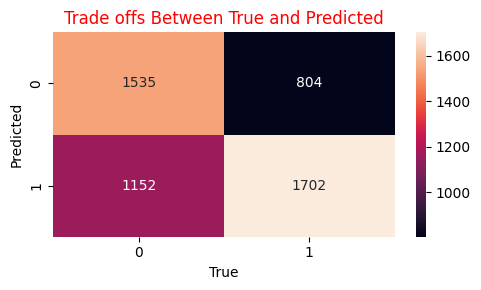

In [68]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
plt.figure(figsize = (5,3))
sns.heatmap(confusion_matrix(y_true, y_predicted), annot = True,fmt = "")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Trade offs Between True and Predicted", color = "red")
plt.tight_layout()

In [69]:
print("Precision Score: ",precision_score(y_true, y_predicted))
print("Recall Score: ", recall_score(y_true, y_predicted))
print("f1 Score: ", f1_score(y_true, y_predicted))
print("Accuracy Score: ", accuracy_score(y_true, y_predicted))

Precision Score:  0.6791699920191541
Recall Score:  0.5963559915907498
f1 Score:  0.6350746268656716
Accuracy Score:  0.6233391103408434


### Submission

In [70]:
submission = pd.DataFrame()
submission['id']=indices
submission['label'] = y_predicted
submission.to_csv('submission.csv',index=False)